In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from plotly.offline import iplot, init_notebook_mode
import pickle
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from datetime import datetime
import plotly.express as px

import os
import pickle
import urllib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [120]:

path = '../../../Atliq Marts Challenge'
fact_order_lines_df=pd.read_csv(path+"/fact_order_lines.csv")
# fact_orders_aggregate_df=pd.read_csv("Atliq Marts Challenge/fact_orders_aggregate.csv")

dim_date=pd.read_csv(path+"/dim_date.csv")
dim_customers=pd.read_csv(path+"/dim_customers.csv")
dim_products=pd.read_csv(path+"/dim_products.csv")
dim_targets_orders=pd.read_csv(path+"/dim_targets_orders.csv")
dim_date=pd.read_csv(path+"/dim_date.csv")
dim_date = dim_date.rename(columns={'date': 'agreed_delivery_date','mmm_yy': 'agreed_delivery_mmm_yy','week_no': 'agreed_delivery_week_num'})





In [121]:
# result =  pd.concat([fact_order_lines_df, fact_orders_aggregate_df], axis=1,join="outer")
# result =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
# esult =pd.merge( fact_order_lines_df, fact_orders_aggregate_df, on=["order_id", "customer_id"])
result =pd.merge( fact_order_lines_df ,dim_customers , how="outer",on=["customer_id"])
result =pd.merge( result ,dim_products , how="outer",on=["product_id"])
result =pd.merge( result ,dim_targets_orders , how="outer",on=["customer_id"])
df =pd.merge( result ,dim_date , how="outer",on=["agreed_delivery_date"])


In [122]:
df.head()

,order_id,order_placement_date,customer_id,product_id,order_qty,agreed_delivery_date,actual_delivery_date,delivery_qty,In Full,On Time,On Time In Full,customer_name,city,product_name,category,ontime_target%,infull_target%,otif_target%,agreed_delivery_mmm_yy,agreed_delivery_week_num
0,FMR32603203,01-Mar-22,789603.0,25891203.0,460.0,02-Mar-22,03-Mar-22,460.0,1.0,0.0,1.0,Info Stores,Vadodara,AM Butter 500,Dairy,92.0,75.0,69.0,Mar 22,W 10
1,FMR32401103,01-Mar-22,789401.0,25891103.0,476.0,02-Mar-22,02-Mar-22,476.0,1.0,1.0,1.0,Propel Mart,Surat,AM Milk 100,Dairy,85.0,79.0,67.0,Mar 22,W 10
2,FMR32320302,01-Mar-22,789320.0,25891203.0,347.0,02-Mar-22,02-Mar-22,347.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Butter 500,Dairy,91.0,81.0,74.0,Mar 22,W 10
3,FMR32320302,01-Mar-22,789320.0,25891302.0,54.0,02-Mar-22,02-Mar-22,54.0,1.0,1.0,1.0,Chiptec Stores,Surat,AM Ghee 150,Dairy,91.0,81.0,74.0,Mar 22,W 10
4,FMR32320202,01-Mar-22,789320.0,25891202.0,211.0,02-Mar-22,03-Mar-22,211.0,1.0,0.0,1.0,Chiptec Stores,Surat,AM Butter 250,Dairy,91.0,81.0,74.0,Mar 22,W 10


In [123]:
df.dropna(inplace=True)

In [124]:
np.sum(df.isna())

order_id                    0
order_placement_date        0
customer_id                 0
product_id                  0
order_qty                   0
agreed_delivery_date        0
actual_delivery_date        0
delivery_qty                0
In Full                     0
On Time                     0
On Time In Full             0
customer_name               0
city                        0
product_name                0
category                    0
ontime_target%              0
infull_target%              0
otif_target%                0
agreed_delivery_mmm_yy      0
agreed_delivery_week_num    0
dtype: int64

In [125]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)
df.rename(columns=lambda x: x.replace("%", "_percent"), inplace=True)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56796 entries, 0 to 57095
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  56796 non-null  object 
 1   order_placement_date      56796 non-null  object 
 2   customer_id               56796 non-null  float64
 3   product_id                56796 non-null  float64
 4   order_qty                 56796 non-null  float64
 5   agreed_delivery_date      56796 non-null  object 
 6   actual_delivery_date      56796 non-null  object 
 7   delivery_qty              56796 non-null  float64
 8   in_full                   56796 non-null  float64
 9   on_time                   56796 non-null  float64
 10  on_time_in_full           56796 non-null  float64
 11  customer_name             56796 non-null  object 
 12  city                      56796 non-null  object 
 13  product_name              56796 non-null  object 
 14  catego

In [127]:
df['actual_delivery_date_formatted'] = pd.to_datetime(df['actual_delivery_date'], format='%d-%b-%y')

df = df.sort_values(by='actual_delivery_date_formatted')

In [128]:
df = df[(df['product_id'] == 25891103)] 

In [129]:
# feature = ['customer_name','product_name','delivery_qty','in_full','on_time','on_time_in_full','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
# feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty']
feature = ['customer_name','product_name','city','category','ontime_target_percent','infull_target_percent','otif_target_percent','order_qty','agreed_delivery_mmm_yy','agreed_delivery_week_num']

df = df[feature]

In [130]:
df = df.drop_duplicates()
# Check for duplicated rows
duplicated_rows = df.duplicated()

# Filter the DataFrame to show duplicated rows
duplicated_df = df[duplicated_rows]

print("Duplicated Rows:")
print(duplicated_df)

Duplicated Rows:
Empty DataFrame
Columns: [customer_name, product_name, city, category, ontime_target_percent, infull_target_percent, otif_target_percent, order_qty, agreed_delivery_mmm_yy, agreed_delivery_week_num]
Index: []


In [131]:
Obj_feature = ['customer_name','product_name','city','category']
for e in Obj_feature:
    tmp = pd.get_dummies(df[e],drop_first=True)
    df.drop([e],axis=1,inplace=True)
    df = pd.concat([df,tmp],axis=1)
df.shape

(3149, 22)

In [132]:
df

,ontime_target_percent,infull_target_percent,otif_target_percent,order_qty,agreed_delivery_mmm_yy,agreed_delivery_week_num,Atlas Stores,Chiptec Stores,Coolblue,Elite Mart,...,Info Stores,Logic Stores,Lotus Mart,Propel Mart,Rel Fresh,Sorefoz Mart,Vijay Stores,Viveks Stores,Surat,Vadodara
82,85.0,80.0,68.0,430.0,Mar 22,W 10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55048,86.0,79.0,68.0,436.0,Mar 22,W 10,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
108,92.0,67.0,62.0,310.0,Mar 22,W 10,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
88,85.0,81.0,69.0,389.0,Mar 22,W 10,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
50,92.0,81.0,75.0,431.0,Mar 22,W 10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57074,87.0,81.0,70.0,414.0,Aug 22,W 36,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
32758,76.0,79.0,60.0,322.0,Aug 22,W 36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
56841,75.0,79.0,59.0,434.0,Aug 22,W 36,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
56950,78.0,79.0,62.0,476.0,Aug 22,W 36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
df['agreed_delivery_week_num']

82       W 10
55048    W 10
108      W 10
88       W 10
50       W 10
         ... 
57074    W 36
32758    W 36
56841    W 36
56950    W 36
56862    W 36
Name: agreed_delivery_week_num, Length: 3149, dtype: object

In [134]:
df['agreed_delivery_mmm_yy']

82       Mar 22
55048    Mar 22
108      Mar 22
88       Mar 22
50       Mar 22
          ...  
57074    Aug 22
32758    Aug 22
56841    Aug 22
56950    Aug 22
56862    Aug 22
Name: agreed_delivery_mmm_yy, Length: 3149, dtype: object

In [135]:
df[['month', 'year']] = df['agreed_delivery_mmm_yy'].str.split(' ', expand=True)
df.drop(['agreed_delivery_mmm_yy'],axis=1,inplace=True)
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Replace month names with numeric values
df['month'] = df['month'].replace(month_mapping)

df[['W', 'agreed_delivery_week_no']] = df['agreed_delivery_week_num'].str.split(' ', expand=True)
df.drop(['agreed_delivery_week_num'],axis=1,inplace=True)
df.drop(['W'],axis=1,inplace=True)

In [136]:

def read_data (months,df):
    i=0
    for month in months:
        if i !=0:
            features_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels_temp=df[df['month']==month] .loc[:, df[df['month']==month] .columns =='order_qty']
            features = pd.concat([features, features_temp])
            labels = pd.concat([labels, labels_temp])
        else :
            features=df[df['month']==month] .loc[:, df[df['month']==month] .columns !='order_qty']
            labels=df[df['month']==month].loc[:, df[df['month']==month] .columns =='order_qty']
        i+=1
    return features,labels


In [137]:
df

,ontime_target_percent,infull_target_percent,otif_target_percent,order_qty,Atlas Stores,Chiptec Stores,Coolblue,Elite Mart,Expert Mart,Expression Stores,...,Propel Mart,Rel Fresh,Sorefoz Mart,Vijay Stores,Viveks Stores,Surat,Vadodara,month,year,agreed_delivery_week_no
82,85.0,80.0,68.0,430.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,3,22,10
55048,86.0,79.0,68.0,436.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,3,22,10
108,92.0,67.0,62.0,310.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,3,22,10
88,85.0,81.0,69.0,389.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,3,22,10
50,92.0,81.0,75.0,431.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3,22,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57074,87.0,81.0,70.0,414.0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,8,22,36
32758,76.0,79.0,60.0,322.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,8,22,36
56841,75.0,79.0,59.0,434.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,8,22,36
56950,78.0,79.0,62.0,476.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,22,36


In [138]:

x_train, y_train = read_data([3,4,5,6],df)
# use data from month 9 as validation set
x_val, y_val = read_data([7],df)

# use data from month 10 as test set
x_test, y_test = read_data([8],df)
print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2041, 22)
y_train shape: (2041, 1) 

x_val shape: (564, 22)
y_val shape: (564, 1) 

x_test shape: (544, 22)
y_test shape: (544, 1)


In [139]:
y_train

,order_qty
82,430.0
55048,436.0
108,310.0
88,389.0
50,431.0
...,...
21981,360.0
22121,312.0
21940,469.0
21998,413.0


In [140]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [141]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [142]:
x_train

,ontime_target_percent,infull_target_percent,otif_target_percent,Atlas Stores,Chiptec Stores,Coolblue,Elite Mart,Expert Mart,Expression Stores,Info Stores,...,Propel Mart,Rel Fresh,Sorefoz Mart,Vijay Stores,Viveks Stores,Surat,Vadodara,month,year,agreed_delivery_week_no
82,85.0,80.0,68.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,22,10
55048,86.0,79.0,68.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,3,22,10
108,92.0,67.0,62.0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,3,22,10
88,85.0,81.0,69.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,3,22,10
50,92.0,81.0,75.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,3,22,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21981,78.0,79.0,62.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,22,27
22121,92.0,67.0,62.0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,6,22,27
21940,78.0,66.0,51.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,22,27
21998,79.0,81.0,64.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,6,22,27


In [143]:
x_train.to_numpy(dtype='float32')

array([[85., 80., 68., ...,  3., 22., 10.],
       [86., 79., 68., ...,  3., 22., 10.],
       [92., 67., 62., ...,  3., 22., 10.],
       ...,
       [78., 66., 51., ...,  6., 22., 27.],
       [79., 81., 64., ...,  6., 22., 27.],
       [86., 77., 66., ...,  6., 22., 27.]], dtype=float32)

In [144]:
normalizer = normalizer_std(x_train) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train.to_numpy(), y_train.to_numpy(), normalizer)
val_dataset = RainfallDatasetFF(x_val.to_numpy(), y_val.to_numpy(), normalizer)
test_dataset = RainfallDatasetFF(x_test.to_numpy(), y_test.to_numpy(), normalizer)

(2041, 22)
(2041, 1)
(564, 22)
(564, 1)
(544, 22)
(544, 1)


In [145]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [146]:
loss_fn = nn.L1Loss()

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [148]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(x_train.shape[1], hidden_size)
        self.do1 = nn.Dropout(p=0.3)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.do2 = nn.Dropout(p=0.3)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.do3 = nn.Dropout(p=0.3)
        self.out = nn.Linear(hidden_size, 1)


    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        x2 = F.relu(self.do1(hd1))
        hd2 = F.relu(self.ff2(x2))
        x3 = F.relu(self.do2(hd2))
        hd3 = F.relu(self.ff3(x3))
        y = F.relu(self.do3(hd3))
        y = self.out(y)
        return y.reshape(-1, 1)

In [149]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 500,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 30
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [150]:
# from torchviz import make_dot
# # Visualize model with torchviz
# sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
# sample_y = model_ff(sample_inputs.to(device))
# make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [151]:
summary(model_ff, input_size=(64, x_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [64, 1]                   --
├─Linear: 1-1                            [64, 500]                 11,500
├─Dropout: 1-2                           [64, 500]                 --
├─Linear: 1-3                            [64, 500]                 250,500
├─Dropout: 1-4                           [64, 500]                 --
├─Linear: 1-5                            [64, 500]                 250,500
├─Dropout: 1-6                           [64, 500]                 --
├─Linear: 1-7                            [64, 1]                   501
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
Total mult-adds (M): 32.83
Input size (MB): 0.01
Forward/backward pass size (MB): 0.77
Params size (MB): 2.05
Estimated Total Size (MB): 2.83

In [152]:
train_losses = []
val_losses = []
learning_rates = []

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

print('Finished Training')

Training epoch 1...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 train loss: 125.1143
Validating epoch 1


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 val loss: 65.2880
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 train loss: 64.6779
Validating epoch 2


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 val loss: 112.0876
Training epoch 3...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 train loss: 64.5984
Validating epoch 3


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 val loss: 80.4060
Training epoch 4...
Current LR: 0.01


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 train loss: 67.6039
Validating epoch 4


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4 val loss: 77.4914
Training epoch 5...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 train loss: 59.8594
Validating epoch 5


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5 val loss: 65.3065
Training epoch 6...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 train loss: 57.4425
Validating epoch 6


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6 val loss: 70.9581
Training epoch 7...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 train loss: 59.1620
Validating epoch 7


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7 val loss: 57.8992
Saving new best model..
Training epoch 8...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 train loss: 59.5356
Validating epoch 8


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8 val loss: 51.3890
Saving new best model..
Training epoch 9...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 train loss: 59.9055
Validating epoch 9


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9 val loss: 59.5795
Training epoch 10...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 train loss: 57.6487
Validating epoch 10


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 val loss: 53.2183
Training epoch 11...
Current LR: 0.002


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 train loss: 58.6198
Validating epoch 11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11 val loss: 52.7407
Training epoch 12...
Current LR: 0.0004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 train loss: 56.7960
Validating epoch 12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12 val loss: 52.7668
Training epoch 13...
Current LR: 0.0004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 train loss: 56.3298
Validating epoch 13


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13 val loss: 52.7716
Training epoch 14...
Current LR: 0.0004


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 train loss: 54.4078
Validating epoch 14


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14 val loss: 57.9850
Training epoch 15...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 train loss: 54.0113
Validating epoch 15


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15 val loss: 54.7634
Training epoch 16...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 train loss: 56.3884
Validating epoch 16


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16 val loss: 56.4640
Training epoch 17...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 train loss: 53.9097
Validating epoch 17


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17 val loss: 56.7459
Training epoch 18...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 train loss: 55.2189
Validating epoch 18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18 val loss: 57.1466
Training epoch 19...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 train loss: 55.2185
Validating epoch 19


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19 val loss: 56.3861
Training epoch 20...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 train loss: 55.8286
Validating epoch 20


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20 val loss: 57.6405
Training epoch 21...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21 train loss: 54.3744
Validating epoch 21


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21 val loss: 56.7245
Training epoch 22...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22 train loss: 55.4521
Validating epoch 22


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22 val loss: 57.7588
Training epoch 23...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23 train loss: 56.4467
Validating epoch 23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23 val loss: 56.7668
Training epoch 24...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24 train loss: 55.7708
Validating epoch 24


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24 val loss: 55.2947
Training epoch 25...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25 train loss: 55.9006
Validating epoch 25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25 val loss: 56.9174
Training epoch 26...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26 train loss: 55.9501
Validating epoch 26


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26 val loss: 55.1498
Training epoch 27...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27 train loss: 53.9216
Validating epoch 27


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27 val loss: 54.7948
Training epoch 28...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28 train loss: 55.2876
Validating epoch 28


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28 val loss: 55.6790
Training epoch 29...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29 train loss: 55.0685
Validating epoch 29


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29 val loss: 57.4772
Training epoch 30...
Current LR: 0.0001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30 train loss: 55.0352
Validating epoch 30


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30 val loss: 58.9826
Finished Training


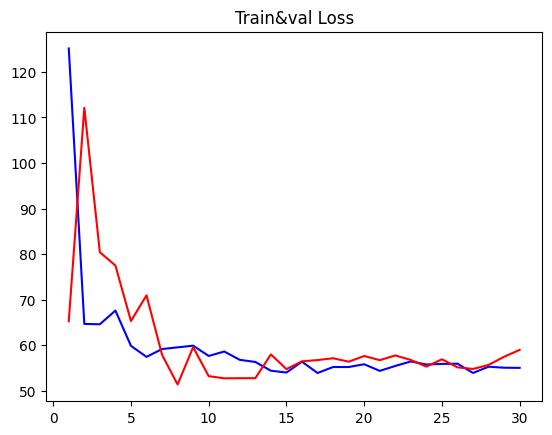

In [153]:
x = [i + 1 for i in range(config['epochs'])]

plt.plot(x, train_losses,color = 'blue')
plt.title("Train&val Loss")
plt.plot(x, val_losses,color = 'red')

plt.show()

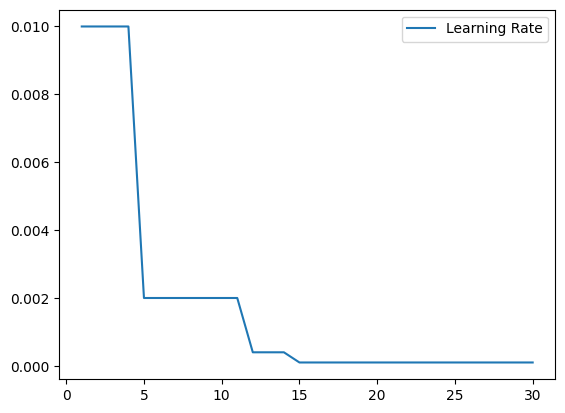

In [154]:
plt.plot(x, learning_rates, label="Learning Rate")
plt.legend()
plt.show()

In [155]:
# Assuming you have defined your model (model_ff) and loaded the test dataset (test_loader)

# Load the best model checkpoint
checkpoint = torch.load("model_ff.pth.tar")
model_ff.load_state_dict(checkpoint['model'])

# Set model to evaluation mode
model_ff.eval()

# Make predictions on the test set
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:  # assuming test_loader yields (inputs, _), where _ is ignored
        inputs = inputs.to(device)  # Transfer data to GPU if available
        y_pred = model_ff(inputs)
        predictions.append(y_pred.cpu().numpy())  # Convert predictions to numpy array and move to CPU

# Concatenate predictions into a single numpy array
predictions = np.concatenate(predictions)

# Now you have predictions for the test set, you can further process or analyze them as needed.


In [156]:
predictions

array([[485.64053],
       [466.43524],
       [429.4958 ],
       [485.64053],
       [469.97552],
       [462.12234],
       [473.19153],
       [454.00394],
       [433.3131 ],
       [433.84143],
       [472.61298],
       [484.27322],
       [447.18933],
       [461.05988],
       [438.8686 ],
       [437.96085],
       [410.542  ],
       [448.64996],
       [454.65552],
       [472.5512 ],
       [463.3258 ],
       [451.22116],
       [473.1916 ],
       [450.09515],
       [455.90262],
       [448.64996],
       [427.05426],
       [473.45984],
       [466.43524],
       [447.74338],
       [452.81836],
       [454.00394],
       [454.65552],
       [452.149  ],
       [461.05988],
       [473.45984],
       [433.8414 ],
       [450.09515],
       [454.039  ],
       [472.02777],
       [462.12234],
       [485.64053],
       [472.5512 ],
       [442.68896],
       [469.97552],
       [455.90262],
       [472.02777],
       [442.97803],
       [484.27322],
       [454.00394],


In [157]:
y_test

,order_qty
28324,481.0
28175,471.0
28193,372.0
56728,397.0
28365,442.0
...,...
57074,414.0
32758,322.0
56841,434.0
56950,476.0


In [158]:
import pandas as pd

# Assuming results_df is your DataFrame containing predictions and y_test
results_df = pd.concat([pd.DataFrame(predictions, columns=['Predictions']), y_test.reset_index(drop=True)], axis=1)

# Rename the columns
results_df = results_df.rename(columns={'Predictions': 'Predict', 'order_qty': 'Actual'})

# Alternatively, you can directly assign the column names during concatenation
# results_df = pd.concat([pd.DataFrame(predictions, columns=['Predict']), y_test.reset_index(drop=True).rename('Actual')], axis=1)

# Now your DataFrame has columns named 'Predict' and 'Actual'


In [159]:
results_df

,Predict,Actual
0,485.640533,481.0
1,466.435242,471.0
2,429.495789,372.0
3,485.640533,397.0
4,469.975525,442.0
...,...,...
539,483.009033,414.0
540,514.204651,322.0
541,473.628723,434.0
542,492.664978,476.0


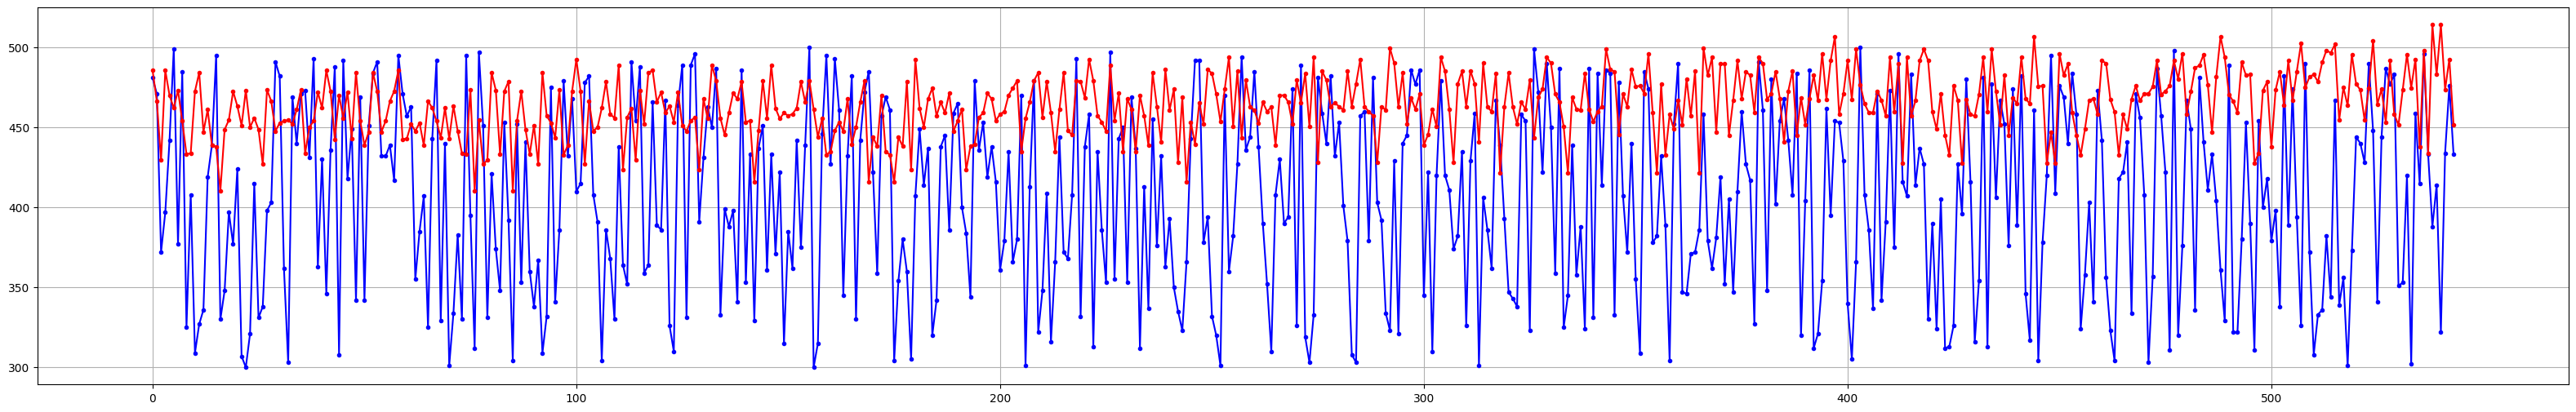

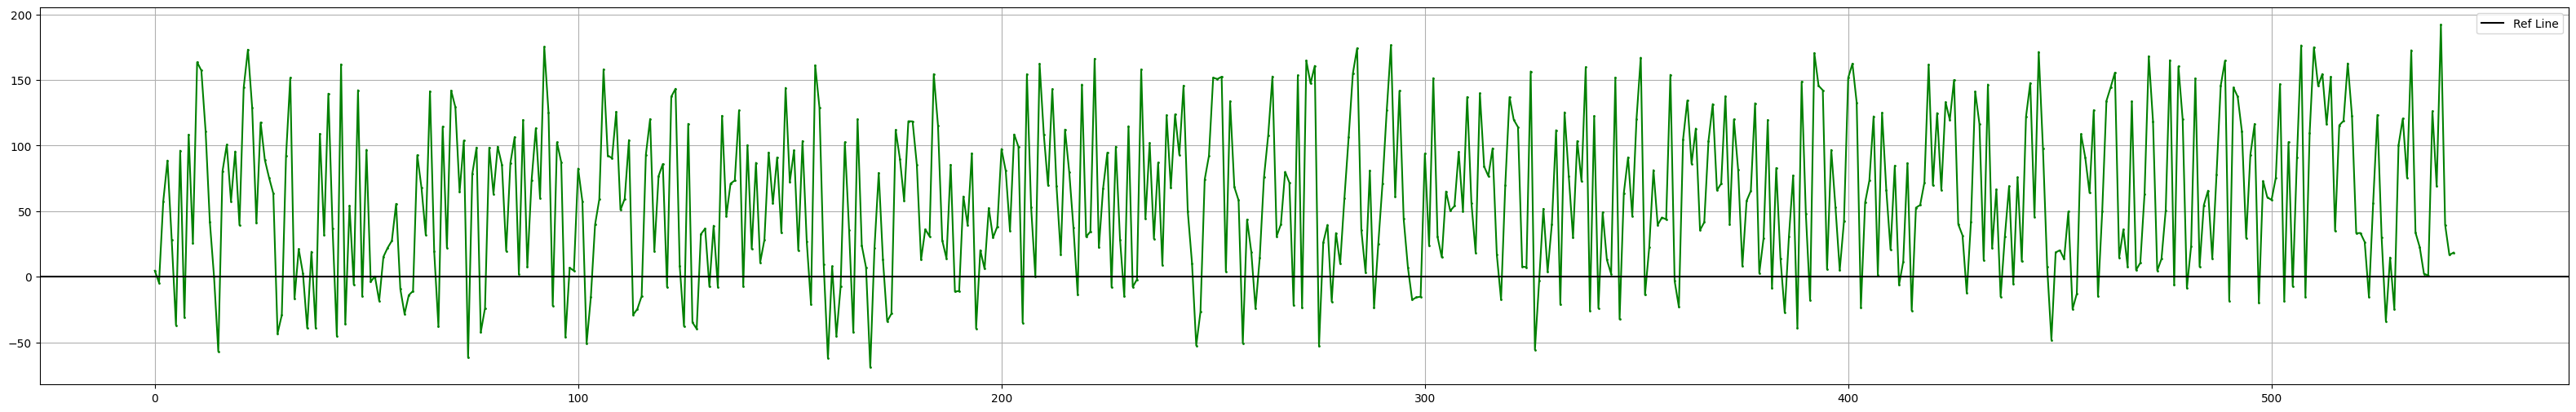

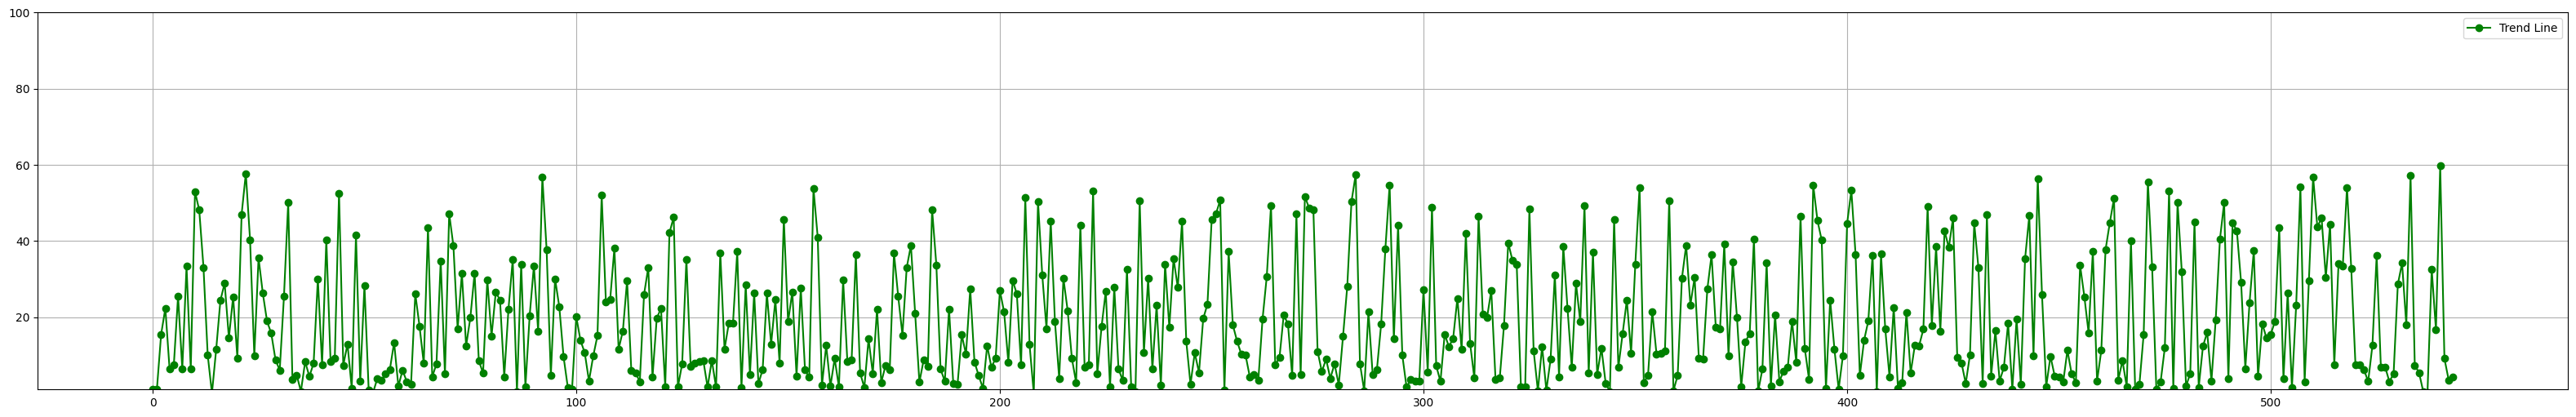

In [161]:
plt.figure(figsize=(40, 6))
plt.plot( results_df['Actual'], color='blue', marker='.', linestyle='-', label='Original Data')
plt.plot( results_df['Predict'], color='red', marker='.', label='6-Week Moving Average')
plt.grid(True)
plt.show()

plt.figure(figsize=(40, 6))
# plt.plot(df['moving_avg']-df['order_qty'], color='red', marker='o', linestyle='-', label='Trend Line')
plt.plot( results_df['Predict']-results_df['Actual'], color='green', marker='o', linestyle='-', markersize=1)
plt.axhline(y=0, color='black', linestyle='-', label='Ref Line')

plt.grid(True)
plt.legend()  # Show legend
plt.show()

plt.figure(figsize=(40, 6))
# plt.plot( (abs(df['moving_avg'] - df['order_qty']) / df['order_qty']) * 100, color='red', marker='o', linestyle='-', label='Trend Line')
plt.plot( (abs(results_df['Predict'] - results_df['Actual']) / results_df['Actual']) * 100, color='green', marker='o', linestyle='-', label='Trend Line')

plt.grid(True)
plt.legend()  # Show legend
plt.ylim(1, 100)  # Set y-axis limits
plt.show()